# EfficientNet-B0 Training – ODIR-5K

## Objective
This notebook trains an **EfficientNet-B0** model for **multi-label ocular disease classification** using the ODIR-5K dataset.

EfficientNet is expected to outperform ResNet-50 and DenseNet-121 due to:
- Compound scaling (depth, width, resolution)
- Better parameter efficiency
- Stronger generalization on small datasets

The training pipeline is kept **consistent** with previous experiments to ensure a fair comparison.

## Section 1 - Import Required Libraries and set paths

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import models, transforms
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
# Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 2050


In [3]:
# Paths & CSVs
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
IMAGE_ROOT = DATA_DIR / "ODIR-5K" / "ODIR-5K"

train_df = pd.read_csv(PROCESSED_DIR / "train.csv")
val_df = pd.read_csv(PROCESSED_DIR / "val.csv")

label_cols = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
NUM_CLASSES = len(label_cols)

print("Train samples:", len(train_df))
print("Val samples:", len(val_df))

Train samples: 5600
Val samples: 1400


## Section 2 - Image Transforms

EfficientNet benefits from slightly stronger augmentation to encourage generalization.

In [4]:
# Transforms
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(
        brightness=0.15,
        contrast=0.15,
        saturation=0.15
    ),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

## Section 3 - Custom PyTorch Dataset

In [5]:
# Dataset Definition
class ODIRDataset(Dataset):
    def __init__(self, dataframe, image_root, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_root = image_root
        self.transform = transform

        self.image_names = self.df["image_name"].values
        self.labels = self.df[label_cols].values.astype(np.float32)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.image_root / "Training Images" / self.image_names[idx]

        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        labels = torch.from_numpy(self.labels[idx])
        return image, labels

In [6]:
# DataLoaders
BATCH_SIZE = 16
NUM_WORKERS = 0

train_dataset = ODIRDataset(train_df, IMAGE_ROOT, train_transforms)
val_dataset = ODIRDataset(val_df, IMAGE_ROOT, val_transforms)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False
)

print("DataLoaders ready.")

DataLoaders ready.


## Section 4 - EfficientNet-B0 Model

In [7]:
# Model Definition
model = models.efficientnet_b0(
    weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1
)

# Replace classifier head
model.classifier[1] = nn.Linear(
    model.classifier[1].in_features,
    NUM_CLASSES
)

model = model.to(device)
print(model.classifier)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\ibaan/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:01<00:00, 15.0MB/s]


Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=8, bias=True)
)


## Loss Function & Optimizer

In [8]:
# Loss & Optimizer
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(
    model.parameters(),
    lr=3e-5,
    weight_decay=1e-4
)

In [9]:
# Accuracy
def multilabel_accuracy(outputs, targets, threshold=0.5):
    probs = torch.sigmoid(outputs)
    preds = (probs >= threshold).float()
    return (preds == targets).float().mean().item()

## Section 5 - Training & Validation Loop

In [10]:
EPOCHS = 8

train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # Training
    model.train()
    train_loss, train_acc = 0.0, 0.0

    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += multilabel_accuracy(outputs, labels)

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    # Validation
    model.eval()
    val_loss, val_acc = 0.0, 0.0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_acc += multilabel_accuracy(outputs, labels)

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)

    print(
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
    )


Epoch 1/8


Validation: 100%|██████████| 88/88 [01:33<00:00,  1.06s/it]


Train Loss: 0.4398 | Train Acc: 0.8274 | Val Loss: 0.3292 | Val Acc: 0.8573

Epoch 2/8


Validation: 100%|██████████| 88/88 [01:33<00:00,  1.06s/it]


Train Loss: 0.3168 | Train Acc: 0.8610 | Val Loss: 0.3003 | Val Acc: 0.8640

Epoch 3/8


Validation: 100%|██████████| 88/88 [01:32<00:00,  1.05s/it]


Train Loss: 0.2988 | Train Acc: 0.8662 | Val Loss: 0.2892 | Val Acc: 0.8696

Epoch 4/8


Validation: 100%|██████████| 88/88 [01:33<00:00,  1.06s/it]


Train Loss: 0.2870 | Train Acc: 0.8702 | Val Loss: 0.2816 | Val Acc: 0.8717

Epoch 5/8


Validation: 100%|██████████| 88/88 [01:33<00:00,  1.06s/it]


Train Loss: 0.2790 | Train Acc: 0.8737 | Val Loss: 0.2788 | Val Acc: 0.8721

Epoch 6/8


Validation: 100%|██████████| 88/88 [01:34<00:00,  1.07s/it]


Train Loss: 0.2731 | Train Acc: 0.8767 | Val Loss: 0.2748 | Val Acc: 0.8739

Epoch 7/8


Validation: 100%|██████████| 88/88 [02:43<00:00,  1.86s/it]


Train Loss: 0.2660 | Train Acc: 0.8783 | Val Loss: 0.2717 | Val Acc: 0.8754

Epoch 8/8


Validation: 100%|██████████| 88/88 [01:33<00:00,  1.06s/it]

Train Loss: 0.2588 | Train Acc: 0.8819 | Val Loss: 0.2698 | Val Acc: 0.8785


## Save Trained Model

In [11]:
checkpoint_dir = PROJECT_ROOT / "checkpoints" / "efficientnet_b0"
checkpoint_dir.mkdir(parents=True, exist_ok=True)

torch.save(model.state_dict(), checkpoint_dir / "efficientnet_b0_odir.pth")
print("Model saved.")

Model saved.


## Save Training History

We save the training and validation metrics to disk so they can be loaded later for model comparison.

In [ ]:
import json

# Create results directory
RESULTS_DIR = PROJECT_ROOT / "results"
RESULTS_DIR.mkdir(exist_ok=True)

In [15]:
history = {
    "train_accuracy": train_acc_hist,
    "val_accuracy": val_acc_hist,
    "train_loss": train_loss_hist,
    "val_loss": val_loss_hist
}

with open(RESULTS_DIR / "efficientnet_b0_history.json", "w") as f:
    json.dump(history, f, indent=4)

print("EfficientNet-B0 training history saved.")

EfficientNet-B0 training history saved.


## Section 6 - Training & Validation Curves

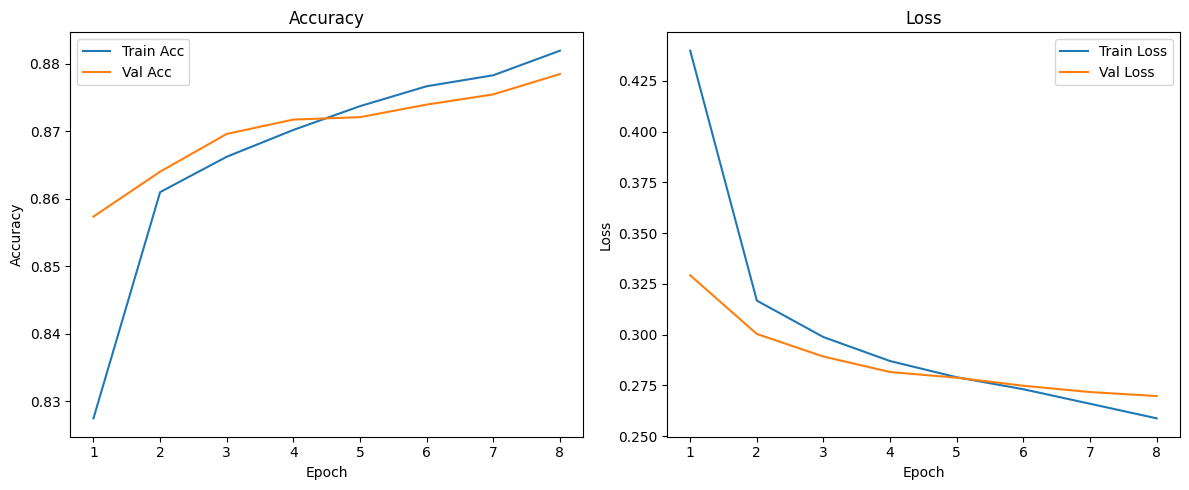

In [12]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_hist, label="Train Acc")
plt.plot(epochs, val_acc_hist, label="Val Acc")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_hist, label="Train Loss")
plt.plot(epochs, val_loss_hist, label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()